<a href="https://colab.research.google.com/github/HNoorazar/Ag/blob/master/remote_sensing/Read_shapefiles_get_EE_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read shapefiles and use them to get images off EE.

In [47]:
import ee
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/vgEj_Nodf9HnGhOExX49I0zDn82pz9MlSFs0B-q63p89UEbkgF7L1O8

Successfully saved authorization token.


# Initialize the Earth Engine

In [0]:
# Initialize the library.
ee.Initialize()

In [49]:
!pip install geopandas

# Import libraries

In [0]:
# Import libraries
import numpy as np
import tensorflow as tp
from IPython.display import Image
import folium
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd
import datetime
import time

from shapely.geometry import Point, Polygon

# Test API

In [51]:
# Test the API
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read shapefile that is in Google Drive.
In order to read the file you have to have
`drive/My Drive/` in the path.

In [0]:
double_crop_shapefile = gpd.read_file("drive/My Drive/shapeFiles/double_dbl_2018/double_dbl_2018.shp")

In [54]:
double_crop_shapefile.head(2)

,CropTyp,Acres,Irrigtn,IntlSrD,LstSrvD,DataSrc,Notes,TRS,County,RttnCrp,CovrCrp,ExctAcr,CropGrp,Shp_Lng,Shap_Ar,geometry
0,"Fallow, Tilled",8,Sprinkler,2003/06/25 00:00:00,2018/10/18 00:00:00,Conservation District,6/25/2003 Some apples are tore out 2015 buckwh...,T09R25E24,Benton,Wheat,None,7.518828,Other,720.962453,30427.616554,"POLYGON ((-119.64070 46.24481, -119.64089 46.2..."
1,"Corn, Field",99,Center Pivot,2003/09/18 00:00:00,2016/12/15 00:00:00,Producer,double cropped green pea/sweet corn,T05R24E4,Benton,"Corn, Sweet",None,98.544261,Cereal Grain,2274.181367,398794.473922,"POLYGON ((-119.80741 45.94627, -119.80725 45.9..."


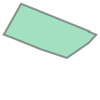

In [55]:
double_crop_shapefile.loc[0, 'geometry']

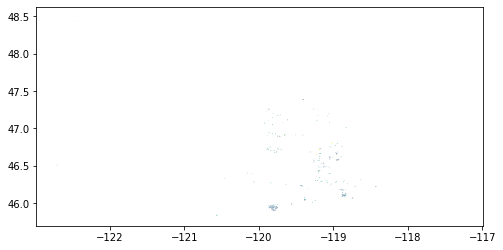

In [56]:
double_crop_shapefile.plot(column='Shap_Ar', figsize=(8, 8));
# double_crop_shapefile.plot(column='Shap_Ar', figsize=(100, 100));

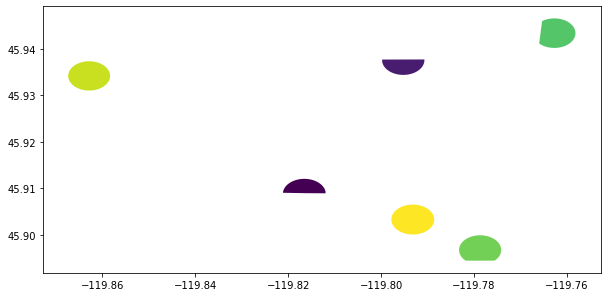

In [57]:
double_crop_shapefile_head = double_crop_shapefile.iloc[23:28, ]
double_crop_shapefile_head = double_crop_shapefile.iloc[50:56, ]
double_crop_shapefile_head.plot(column='Shap_Ar', figsize=(10, 10));

# End of reading ShapeFile

# Start downloading images off EE.

In [58]:
# Import a DEM and display a thumbnail of it.
dem = ee.Image('USGS/SRTMGL1_003')
Image(url=dem.updateMask(dem.gt(0))
  .getThumbUrl({'min': 0, 'max': 4000, 'dimensions': 512,
                'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

# Define Functions

In [0]:
############################################################################
def addTime(image):
  time_added = image.addBands(image.metadata('system:time_start').divide(1000 * 60 * 60 * 24 * 365))
  return (time_added)

############################################################################
##
##    compute NDVI index
##

def compute_collection_NDVI(image_collection):
  collection_NVDI = image_collection.map(compute_image_NDVI)
  return (collection_NVDI)

def compute_image_NDVI(an_image, ndvi_bands=['B8', 'B4']):
  image_NDVI = an_image.normalizedDifference(ndvi_bands).rename('NDVI')
  return (image_NDVI)

############################################################################
##
##    add NDVI index to the image collection
##

def add_NDVI_to_image_collection(image_collection):
  return (image_collection.map(add_NDVI_to_image_to_use_for_map)) # addNDVI

def add_NDVI_to_image_to_use_for_map(image, ndvi_bands=['B8', 'B4']):
  ndvi = image.normalizedDifference(ndvi_bands).rename('NDVI');
  return image.addBands(ndvi)

############################################################################
##
##    Convert shapely.geometry.polygon.Polygon to ee.geometry.Geometry
##    so it can be used as boundaries to download images from Earth Engine
##
def convert_panda_geometry_to_json_type_4_filterBounds(shapely_polygon):
  #
  # input is of type: shapely.geometry.polygon.Polygon
  # output is of type ee.geometry.Geometry
  A = gpd.GeoSeries([shapely_polygon]).__geo_interface__

  ee_geometry_Geometry = ee.Geometry.Polygon([A["features"][0]["geometry"]["coordinates"][0]])
  return(ee_geometry_Geometry)

def convert_panda_geometry_to_json_type_4_filterBounds_list(shapely_polygon):
  #
  # input is of type: shapely.geometry.polygon.Polygon
  # output is of type ee.geometry.Geometry
  A = gpd.GeoSeries([shapely_polygon]).__geo_interface__

  Listt = [list(row) for row in A["features"][0]["geometry"]["coordinates"][0]]
  ee_geometry_Geometry = ee.Geometry.Polygon(Listt)
  return(ee_geometry_Geometry)

# Define some universal variables

The band names of Sentinel-2A and their description is located at the following link: 


https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

In [0]:
sentinel2A_all_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 
                        'B8', 'B9', 'B10', 'B11', 'B12', 
                        'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 
                        'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 
                        'QA10', 'QA20', 'QA60']
                        
RGB_bands = ['B4', 'B3', 'B2']
sentinel2A_some_bands = ['B4', 'B3', 'B2', 'SCL', 'AOT']

# B8 is NIR and B4 is read
NDVI_bands = ['B8', 'B4']

In [0]:
class Parameters:
  def __init__(self, region_polygon, start_date, end_date, ndvi_bands= ['B8', 'B4']):
    self.region_polygon = region_polygon
    self.ndvi_bands = ndvi_bands
    self.start_date = start_date
    self.end_date = end_date

# Set up the image properties we want below.

Example for downloading images of landsat:
[Link to the example](https://stackoverflow.com/questions/39219705/how-to-download-images-using-google-earth-engines-python-api/41289973#41289973)


# Load up Images of Sentinel and LandSat

In [0]:
# we need to work on the following to get the damn images
sentinel_2A = ee.ImageCollection('COPERNICUS/S2')

# Load a Sentinel 2 image and select NDVI bands.
sentinel_2A_NDVI_bands = ee.Image('COPERNICUS/S2').select(NDVI_bands);

# Load a landsat image and NDVI bands.
landsat_NDVI_bands = ee.Image('LANDSAT/LC8_L1T_TOA/LC81230322014135LGN00').select(NDVI_bands);

# Load a landsat image and select three RGB bands.
landsat_RGB = ee.Image('LANDSAT/LC8_L1T_TOA/LC81230322014135LGN00').select(RGB_bands);

# Evolution of learning how to get from a GeoPanda data frame to a geometry that we can work with:

```
# type(double_crop_shapefile.loc[20, 'geometry'])
# type(gpd.GeoSeries([double_crop_shapefile.loc[20, 'geometry']]).to_json())
# A = gpd.GeoSeries([double_crop_shapefile.iloc[20, 15]]).__geo_interface__
# type(A)
# A.keys()
# A["features"][0].keys()
# A["features"][0]["geometry"].keys()
# A["features"][0]["geometry"]["coordinates"]
# ee.Geometry.Polygon([A["features"][0]["geometry"]["coordinates"][0]])

shapely_polygon = double_crop_shapefile.iloc[20, 15]
type(convert_panda_geometry_to_json_type_4_filterBounds(shapely_polygon))
```

# Define parameters

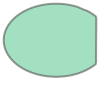

In [63]:
double_crop_shapefile.loc[1, 'geometry']

# process of learning why things were not working due to a mistake:

```
####################################
A = gpd.GeoSeries([double_crop_shapefile.iloc[20, 15]]).__geo_interface__
convert_panda_geometry_to_json_type_4_filterBounds(double_crop_shapefile.loc[20, 'geometry'])
type(ee.Geometry.Polygon([A["features"][0]["geometry"]["coordinates"][0]]))
ee.Geometry.Polygon([A["features"][0]["geometry"]["coordinates"][0]]) == convert_panda_geometry_to_json_type_4_filterBounds(double_crop_shapefile.loc[20, 'geometry'])

####################################
A = gpd.GeoSeries([double_crop_shapefile.loc[20, 'geometry']]).__geo_interface__
B = A["features"][0]["geometry"]["coordinates"][0]
ee.Geometry.Polygon(B)
ee.Geometry.Polygon([A["features"][0]["geometry"]["coordinates"][0]]) == B
```

In [0]:
start_dt = '2018-03-1'
end_dt = '2018-10-30'

# convert geometry of a field to a format usable by filterBounds function in EE.
a_double_field = convert_panda_geometry_to_json_type_4_filterBounds_list(double_crop_shapefile.loc[0, 'geometry'])

'''
col = ee.ImageCollection('LANDSAT/LC08/C01/T1')\
        .filterDate('2015-01-01','2015-04-30')\
        .filterBounds(region)
'''

a_double_crop_field_image_collection = ee.ImageCollection('COPERNICUS/S2').filter( # searches all sentinel 2 imagery pixels...
                                                      ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 
                                                                   10)).filterDate( start_dt,
                                                                                    end_dt).filterBounds(a_double_field).select(NDVI_bands)

# a_double_crop_field_image_collection

# Get fucking informations of the imageCollection

In [124]:
a_double_crop_field_image_collection.getInfo().keys()

dict_keys(['type', 'bands', 'id', 'version', 'properties', 'features'])

In [127]:
a_double_crop_field_image_collection.getInfo()['features'][0].keys()

dict_keys(['type', 'bands', 'id', 'version', 'properties'])

In [128]:
a_double_crop_field_image_collection.getInfo()['features'][0]['bands']

[{'crs': 'EPSG:32610',
  'crs_transform': [10, 0, 699960, 0, -10, 5200020],
  'data_type': {'max': 65535,
   'min': 0,
   'precision': 'int',
   'type': 'PixelType'},
  'dimensions': [10980, 10980],
  'id': 'B8'},
 {'crs': 'EPSG:32610',
  'crs_transform': [10, 0, 699960, 0, -10, 5200020],
  'data_type': {'max': 65535,
   'min': 0,
   'precision': 'int',
   'type': 'PixelType'},
  'dimensions': [10980, 10980],
  'id': 'B4'}]

# Get metadata of the image collection.

[Link to the example](https://samapriya.github.io/gee-py/projects/collection_meta/) for getting metadata.

### Get Number of Images in the ImageCollection

In [129]:
count = a_double_crop_field_image_collection.size()
print('Count: ', str(count.getInfo()) + '\n')

Count:  45



In [130]:
# Get the date range of images in the a_double_crop_field_image_collection.
range = a_double_crop_field_image_collection.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])

# this shit is in milliseconds. We need to divide by 1000 otherwise, 
# conversion to readable will not make sense.
#
start_time_epoch = ee.Date(range.get('min')).getInfo()["value"]/1000
end_time_epoch = ee.Date(range.get('max')).getInfo()["value"]/1000

readable_start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time_epoch))
readable_end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time_epoch))
print('Epoch Date range: ', str(start_time_epoch), " - ", str(end_time_epoch) +'\n')
print('Readable Date range: ', readable_start_time, " - ", readable_end_time +'\n')

Epoch Date range:  1520362440.04  -  1540234890.18

Readable Date range:  2018-03-06 18:54:00  -  2018-10-22 19:01:30



```
eee_list = convert_panda_geometry_to_json_type_4_filterBounds_list(double_crop_shapefile.loc[0, 'geometry'])
eee_tupe = convert_panda_geometry_to_json_type_4_filterBounds(double_crop_shapefile.loc[0, 'geometry'])
print(double_crop_shapefile.loc[0, 'geometry'])
```

In [0]:
a_double_crop_field_image_collection_NDVI1 = add_NDVI_to_image_collection(a_double_crop_field_image_collection)

In [132]:
a_double_crop_field_image_collection_NDVI1
count = a_double_crop_field_image_collection_NDVI1.size()
print('Count: ', str(count.getInfo()) + '\n')

Count:  45



In [0]:
# a_double_crop_field_image_collection_NDVI1.getInfo()
# sunStats = a_double_crop_field_image_collection_NDVI2.aggregate_stats('SUN_ELEVATION');
# print('a_double_crop_field_image_collection_NDVI1 statistics: ', sunStats);

# Get the band names 
This is equivalent of an_image.bandNames() of the javascript.

In [171]:
# a_double_crop_field_image_collection_NDVI1.getInfo()['features'][0]['bands']
a_double_crop_field_image_collection_NDVI1.first().bandNames().getInfo()

['B8', 'B4', 'NDVI']

In [183]:
type(a_double_crop_field_image_collection_NDVI1.first().bandNames())

ee.ee_list.List

In [83]:
ee.Chart.image.doySeriesByYear({
               imageCollection: a_double_crop_field_image_collection_NDVI1, 
               bandName: 'NDVI', 
               regionReducer: ee.Reducer.mean(), 
               scale: 500});

AttributeError: ignored